In [72]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid', palette = 'dark')
import plotly
from adjustText import adjust_text
from IPython.display import display, HTML

# These local modules use data generated from raw data
import get_data
import tackle_plot

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
plotly.offline.init_notebook_mode(connected=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
from IPython.core.display import HTML as Center
Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    margin:0 0 0 -80px;
}
</style> """)

In [2]:
def plot(gameId, playId):
    game = get_data.game(gameId)
    play = get_data.play(gameId, playId)
    tracking = get_data.tracking(gameId, playId).reset_index()
    
    date = game['gameDate'].item()
    tacklers = get_data.tacklers(gameId, playId)
    carrier = play['ballCarrierId'].item()
    offence = play['possessionTeam'].item()
    defence = play['defensiveTeam'].item()
    down = play['down'].item()
    yardstogo = play['yardsToGo'].item()
    ablos = play['absoluteYardlineNumber'].item()   
    
    fig0, fig = tackle_plot.plot(tracking, date, tacklers, carrier, offence, defence, down, yardstogo, ablos) 
    
    fig0.show(config={'displayModeBar': False})    
    fig.show(config={'displayModeBar': False})

Select the model with four features for application.

In [3]:
with open('../saved_models/gb_tree_1.pkl', 'rb') as file:
    gb_model = pickle.load(file)

In [4]:
progress_df3 = pd.read_csv('../newdata/progress_df3.csv')

In [5]:
progress_df3.head()

,gameId,playId,progress,lst_event,near_defender,near_defender_MPD,near_dist,leverage,caught_width,caught_x,SoF,has_blocker
0,2022100908,3537,2.340000,1,43306.0,0.318461,3.881714,0,2.07,57.560001,26.639809,0
1,2022091111,1148,2.779999,1,47843.0,0.831594,2.832137,1,0.23,51.650002,14.015269,0
2,2022103001,2165,9.760002,1,46205.0,3.444545,7.086353,0,18.29,23.480000,186.281002,1
3,2022092511,2903,6.030006,1,52527.0,2.751467,3.919005,0,9.83,31.449997,18.348826,1
4,2022091102,3336,0.777499,1,46077.0,0.735391,0.860930,0,24.29,48.610001,8.584447,0


Generated survival functions for all the short pass plays from the previous cleaned data.

In [6]:
ytg_probs_df = progress_df3.copy()

In [7]:
X = ytg_probs_df[['near_defender_MPD', 'near_dist', 'SoF', 'has_blocker']]
ytg_probs_df['sf'] = gb_model.predict_survival_function(X)

In [8]:
# X = ytg_probs_df[['near_defender_MPD', 'near_dist', 'leverage', 'caught_width', 'SoF', 'has_blocker']]
# ytg_probs_df['sf'] = gb_model.predict_survival_function(X)

In [9]:
ytg_probs = []
ytg_caughts = []
offenseTeam = []
defenseTeam = []

for index, row in ytg_probs_df.iterrows():
    gameId, playId = row['gameId'], row['playId']
    play = get_data.play(gameId, playId)  
    
    yardsToGo = play['yardsToGo'].item()
    LoS = play['yardlineNumber'].item()    
    offense = play['possessionTeam'].item()
    defense = play['defensiveTeam'].item()
        
    caught_x = row['caught_x']
    sf = row['sf']
    survival_function = pd.DataFrame({'probability': sf.y}, index=sf.x)
    
    ytg_caught = yardsToGo - (caught_x - 10 - LoS)    
    if ytg_caught <= 0:
        ytg_prob = 1.0
    else:
        ytg_caught = survival_function.index[abs(survival_function.index - ytg_caught).argmin()]
        ytg_prob = survival_function.loc[ytg_caught, 'probability']
    
    ytg_probs.append(ytg_prob)
    ytg_caughts.append(ytg_caught)
    offenseTeam.append(offense)
    defenseTeam.append(defense)

In [10]:
ytg_probs_df['ytg_probs'] = ytg_probs
ytg_probs_df['offenseTeam'] = offenseTeam
ytg_probs_df['defenseTeam'] = defenseTeam
ytg_probs_df['ytg_caughts'] = ytg_caughts

In [11]:
# ytg_probs_df.to_csv('../newdata/ytg_probs_df.csv', index = False)

In [66]:
def analyze_play(gameId, playId):
    '''
    Analyzes and visualizes a specific play in a game.

    Args:
    - gameId (int or str): The unique identifier for the game.
    - playId (int or str): The unique identifier for the play within the game.
    '''
    plot(gameId, playId)
    
    row = ytg_probs_df.query('gameId == @gameId & playId == @playId')
    ytg_caught = row['ytg_caughts'].item()
    ytg_prob = row['ytg_probs'].item()
    survival_function = row['sf'].item()
    
    print(f'                          yards to go after caught: {round(ytg_caught, 2)}')
    print(f'                          probability for down: {round(ytg_prob, 2)}')   
    plt.figure(figsize=(6, 3))
    plt.plot(survival_function.x, survival_function.y, label = 'down probability')
    plt.axvline(x=ytg_caught, color='tan', linestyle='--', label = 'yards to go after caught')

    plt.legend()

By inputting the 'gameId' and 'playId' of the play of interest, function 'analyze_play' in notebook 'model_application' will display:

- An interactive plot to show each available frame of this play; 
- Yards remained to achieve a down after the ball is caught and the probability of the down's occurrence;
- The survival curve of the probability of the down's occurrence.


                          yards to go after caught: -6.65
                          probability for down: 1.0


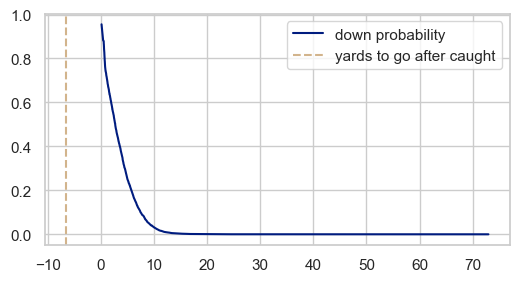

In [73]:
analyze_play(2022091111, 1148)

                          yards to go after caught: 21.47
                          probability for down: 0.29


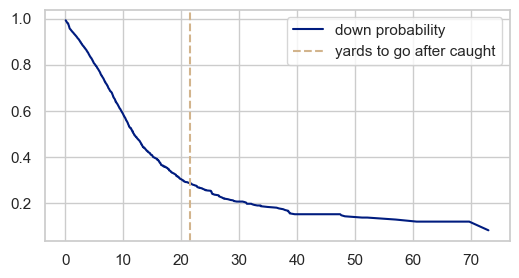

In [71]:
analyze_play(2022103001, 2165)

In [15]:
ytg_probs_df.shape

(5024, 17)

In [16]:
ytg_probs_df.defenseTeam.value_counts()

defenseTeam
ATL    212
ARI    199
BAL    191
MIA    190
TEN    186
      ... 
LAC    132
CLE    125
NYG    124
HOU    119
SF     118
Name: count, Length: 32, dtype: int64

In [17]:
ytg_probs_df.offenseTeam.value_counts()

offenseTeam
TB     225
IND    214
ARI    212
CIN    209
LAC    196
      ... 
DEN    127
DAL    122
ATL    104
TEN     96
CHI     81
Name: count, Length: 32, dtype: int64

I calculated the average probability of down's occurrence related to each team in each play, as offense and as defense separately, excluding the plays where the down was already achieved when the ball was caught. Plotting the average probability against the average true progress verifies that generally, the defense team which causes a lower probability of down's occurrence ended up with lower progress gained by the offense team after the ball is caught.

In [18]:
ytg_probs_plot = ytg_probs_df[ytg_probs_df.ytg_probs != 1]

In [19]:
ytg_probs_plot.shape

(2573, 17)

In [20]:
progress_offense = ytg_probs_plot.groupby('offenseTeam', as_index = False)[['progress']].mean()
progress_offense.rename(columns = {'progress': 'progress_as_O', 'offenseTeam': 'Team'}, inplace = True)

In [21]:
progress_defense = ytg_probs_plot.groupby('defenseTeam', as_index = False)[['progress']].mean()
progress_defense.rename(columns = {'progress': 'progress_as_D', 'defenseTeam': 'Team'}, inplace = True)

In [22]:
ytg_probs_offense = ytg_probs_plot.groupby('offenseTeam', as_index = False)[['ytg_probs']].mean()
ytg_probs_offense.rename(columns = {'ytg_probs': 'ytg_probs_as_O', 'offenseTeam': 'Team'}, inplace = True)

In [23]:
ytg_probs_defense = ytg_probs_plot.groupby('defenseTeam', as_index = False)[['ytg_probs']].mean()
ytg_probs_defense.rename(columns = {'ytg_probs': 'ytg_probs_as_D', 'defenseTeam': 'Team'}, inplace = True)

In [24]:
ytg_probs_team = progress_offense.merge(
    progress_defense, on = 'Team', how = 'outer').merge(
    ytg_probs_offense, on = 'Team', how = 'outer').merge(
    ytg_probs_defense, on = 'Team', how = 'outer')

In [25]:
ytg_probs_team.sort_values(by = 'ytg_probs_as_D', ascending = True).head()

,Team,progress_as_O,progress_as_D,ytg_probs_as_O,ytg_probs_as_D
29,TB,4.852624,4.707296,0.260586,0.226802
4,CAR,8.921233,5.109956,0.279716,0.230921
13,IND,5.276728,6.631447,0.253570,0.264550
7,CLE,4.650464,6.203539,0.388557,0.267255
30,TEN,7.259698,4.382890,0.274614,0.267471


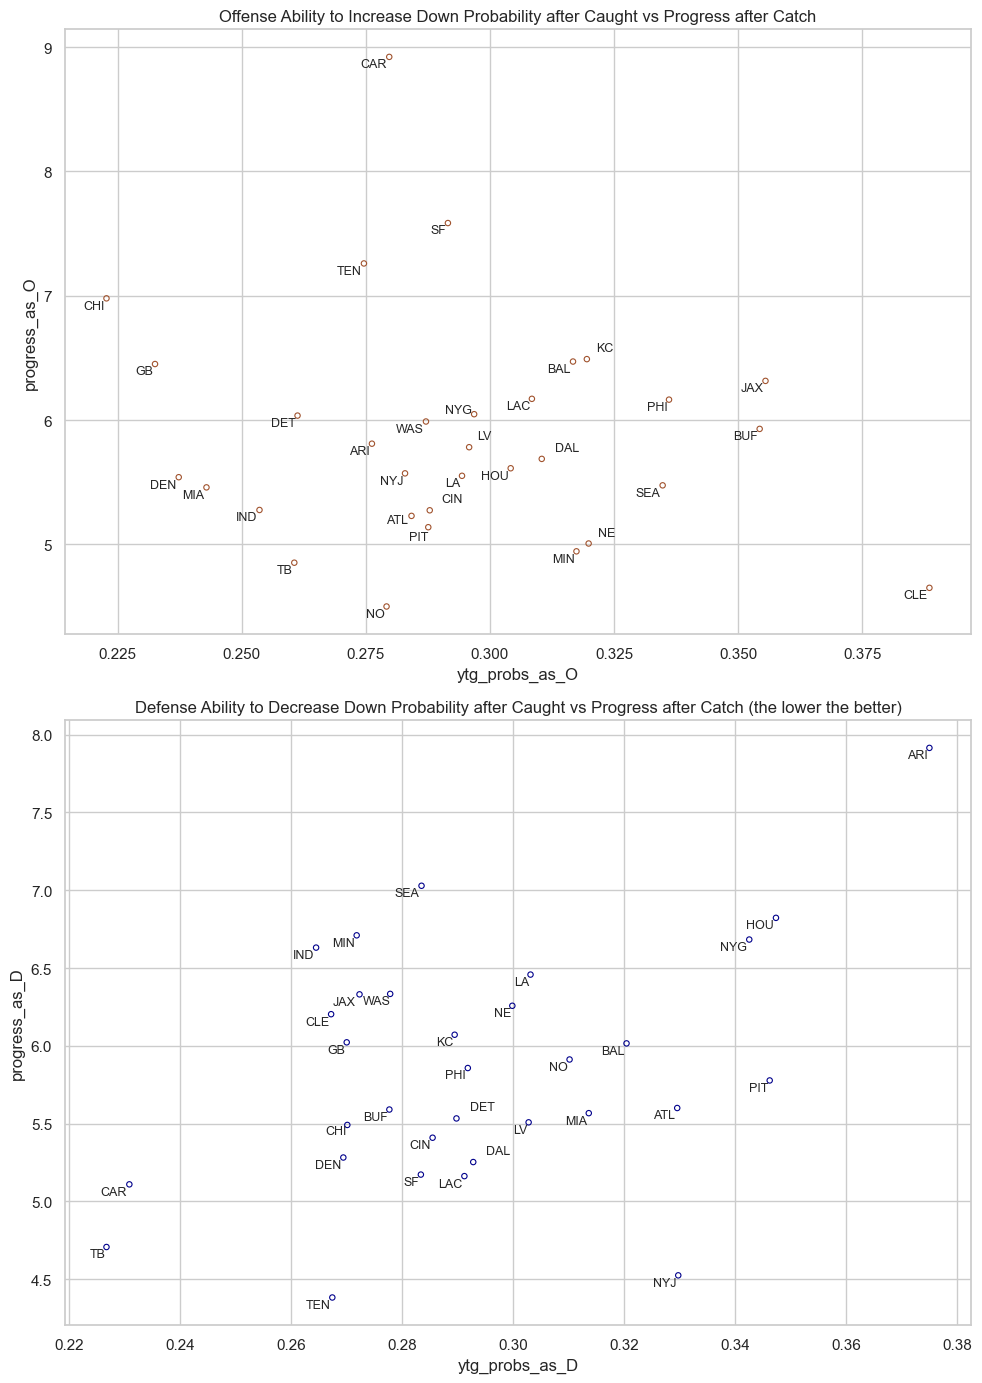

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14))
sns.scatterplot(data=ytg_probs_team, x='ytg_probs_as_O', y='progress_as_O', s=15, 
                edgecolor='sienna', linewidth=0.8, facecolors='none', ax = ax1)

texts_1 = []
for index, row in ytg_probs_team.iterrows():
    texts_1.append(ax1.text(row['ytg_probs_as_O'], row['progress_as_O'], row['Team'], fontsize=9))
adjust_text(texts_1, ax=ax1)

ax1.set_title('Offense Ability to Increase Down Probability after Caught vs Progress after Catch')
ax1.set_xlabel('ytg_probs_as_O')
ax1.set_ylabel('progress_as_O')

sns.scatterplot(data=ytg_probs_team, x='ytg_probs_as_D', y='progress_as_D', s=15, 
                edgecolor='darkblue', linewidth=0.8, facecolors='none', ax = ax2)

texts_2 = []
for index, row in ytg_probs_team.iterrows():
    texts_2.append(ax2.text(row['ytg_probs_as_D'], row['progress_as_D'], row['Team'], fontsize=9))
adjust_text(texts_2, ax=ax2)

ax2.set_title('Defense Ability to Decrease Down Probability after Caught vs Progress after Catch (the lower the better)')
ax2.set_xlabel('ytg_probs_as_D')
ax2.set_ylabel('progress_as_D')

plt.tight_layout()
plt.show()